In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad

import numpy as np
import matplotlib.pyplot as plt




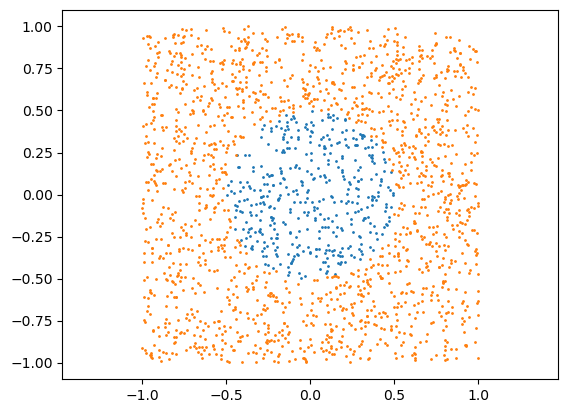

In [2]:
## Generate the dataset
np.random.seed(98235)
torch.manual_seed(98235)

N = 2000  # number of data points

# Training data
train_data = np.random.rand(N, 2) * 2 - 1  # Generate random points in [-1, 1] x [-1, 1]
train_labels = np.sqrt(train_data[:, 0]**2 + train_data[:, 1]**2) > 1/2  # Calculate r and assign labels
train_labels = train_labels.astype(np.float32)

# Plot the data
plt.figure()
plt.scatter(train_data[train_labels == 0, 0], train_data[train_labels == 0, 1], s=1)
plt.scatter(train_data[train_labels == 1, 0], train_data[train_labels == 1, 1], s=1)
plt.axis('equal')
plt.show()

# Test data
test_data = np.random.rand(N//5, 2) * 2 - 1
test_labels = np.sqrt(test_data[:, 0]**2 + test_data[:, 1]**2) > 1/2
test_labels = test_labels.astype(np.float32)

# partial data, keep only data with x > 0
train_data_restriced = train_data[train_data[:, 0] > 0]
train_labels_restriced = train_labels[train_data[:, 0] > 0]



# Convert to PyTorch tensors and create loaders
train_data = torch.tensor(train_data, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

test_data = torch.tensor(test_data, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

train_data_restriced = torch.tensor(train_data_restriced, dtype=torch.float32)
train_labels_restriced = torch.tensor(train_labels_restriced, dtype=torch.float32)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)
train_dataset_restricted = TensorDataset(train_data_restriced, train_labels_restriced)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader_restricted = DataLoader(train_dataset_restricted, batch_size=32, shuffle=True)

Epoch 1, train loss: 0.650, test loss: 0.629
Epoch 101, train loss: 0.129, test loss: 0.135
Epoch 201, train loss: 0.021, test loss: 0.039
Epoch 301, train loss: 0.014, test loss: 0.031
Epoch 401, train loss: 0.010, test loss: 0.028
Epoch 501, train loss: 0.009, test loss: 0.039
Epoch 601, train loss: 0.010, test loss: 0.026
Epoch 701, train loss: 0.007, test loss: 0.023
Epoch 801, train loss: 0.009, test loss: 0.022
Epoch 901, train loss: 0.007, test loss: 0.023
Epoch 1, train loss restricted: 0.663, test loss restricted: 0.647
Epoch 101, train loss restricted: 0.188, test loss restricted: 0.432
Epoch 201, train loss restricted: 0.044, test loss restricted: 1.132
Epoch 301, train loss restricted: 0.024, test loss restricted: 1.500
Epoch 401, train loss restricted: 0.018, test loss restricted: 1.688
Epoch 501, train loss restricted: 0.016, test loss restricted: 1.767
Epoch 601, train loss restricted: 0.015, test loss restricted: 1.823
Epoch 701, train loss restricted: 0.011, test loss 

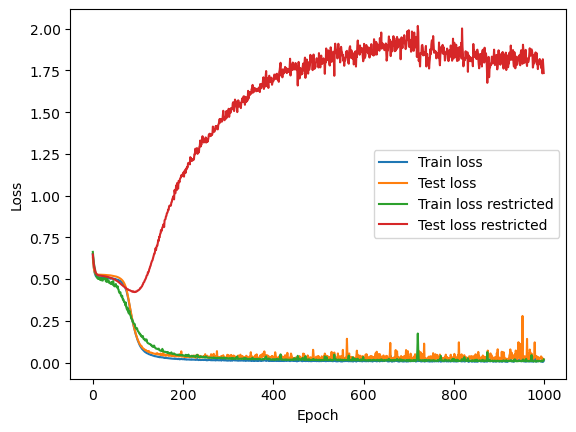

In [3]:
# Define the model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x
    
model = Net()
model_restricted = Net()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
optimizer_restricted = optim.SGD(model_restricted.parameters(), lr=1e-3, momentum=0.9)

# Train the model, store train and test loss, print the loss every epoch
train_loss = []
test_loss = []


for epoch in range(1000):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))
    
    model.eval()
    running_loss = 0.0
    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        running_loss += loss.item()
    test_loss.append(running_loss / len(test_loader))

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, train loss: {train_loss[-1]:.3f}, test loss: {test_loss[-1]:.3f}")

# Train the model on the restricted data
train_loss_restricted = []
test_loss_restricted = []

for epoch in range(1000):
    model_restricted.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader_restricted):
        inputs, labels = data
        optimizer_restricted.zero_grad()
        outputs = model_restricted(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer_restricted.step()
        running_loss += loss.item()
    train_loss_restricted.append(running_loss / len(train_loader_restricted))
    
    model_restricted.eval()
    running_loss = 0.0
    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs = model_restricted(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        running_loss += loss.item()
    test_loss_restricted.append(running_loss / len(test_loader))

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, train loss restricted: {train_loss_restricted[-1]:.3f}, test loss restricted: {test_loss_restricted[-1]:.3f}")


# Plot the loss 

plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Test loss")
plt.plot(train_loss_restricted, label="Train loss restricted")
plt.plot(test_loss_restricted, label="Test loss restricted")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [7]:
def evaluate_model(model, data, SO2_gen):
    # Forward pass
    outputs = model(data).squeeze()  # Ensure output is correctly squeezed for binary classification

    # Compute gradients
    grad_outputs = torch.ones_like(outputs)  # Same shape as model output
    gradients = grad(outputs=outputs, inputs=data,
                     grad_outputs=grad_outputs, create_graph=True)[0]

    # Perform matrix multiplication with SO(2) generator and then with the input data
    result = torch.matmul(torch.matmul(gradients, SO2_gen), data.unsqueeze(-1))

    # Assuming the result tensor is [N, 2, 1], flatten for mean and std calculation
    result_flattened = result.view(-1)

    # Compute and return mean and standard deviation
    return result_flattened.mean().item(), result_flattened.std().item()

# Assuming SO2_gen and train_data_restriced are defined and set up correctly
SO2_gen = torch.tensor([[0, 1], [-1, 0]], dtype=torch.float32)
train_data.requires_grad_(True)  # Ensure gradients are computed for the input data

# Evaluate both models
mean_std_model = evaluate_model(model, train_data, SO2_gen)
mean_std_model_restricted = evaluate_model(model_restricted, train_data, SO2_gen)

print(f"Model: Mean = {mean_std_model[0]}, Std = {mean_std_model[1]}")
print(f"Model (Restricted): Mean = {mean_std_model_restricted[0]}, Std = {mean_std_model_restricted[1]}")
train_data.requires_grad_(False);  # Ensure gradients are computed for the input data


Model: Mean = -0.00022748636547476053, Std = 3.0053348541259766
Model (Restricted): Mean = -0.0014288646634668112, Std = 2.5857622623443604


Epoch 1, train loss restricted SO2: 0.672, test loss restricted SO2: 0.616
Epoch 101, train loss restricted SO2: 0.165, test loss restricted SO2: 0.150
Epoch 201, train loss restricted SO2: 0.165, test loss restricted SO2: 0.127
Epoch 301, train loss restricted SO2: 0.165, test loss restricted SO2: 0.094
Epoch 401, train loss restricted SO2: 0.166, test loss restricted SO2: 0.076
Epoch 501, train loss restricted SO2: 0.162, test loss restricted SO2: 0.074
Epoch 601, train loss restricted SO2: 0.163, test loss restricted SO2: 0.078
Epoch 701, train loss restricted SO2: 0.162, test loss restricted SO2: 0.075
Epoch 801, train loss restricted SO2: 0.171, test loss restricted SO2: 0.080
Epoch 901, train loss restricted SO2: 0.165, test loss restricted SO2: 0.074


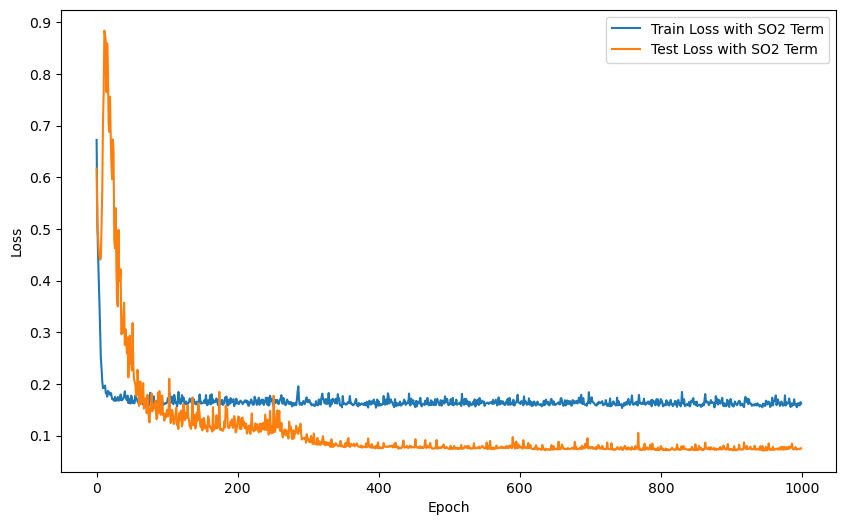

In [10]:
# Train a new model like beore, on the restricted data, but add the SO(2) invariance loss term

model_restricted_SO2 = Net()

# Assuming criterion and optimizer_restricted are defined
criterion = nn.BCELoss()
optimizer_restricted = torch.optim.Adam(model_restricted_SO2.parameters(), lr=0.001)

train_loss_restricted_SO2 = []
test_loss_restricted_SO2 = []

for epoch in range(1000):
    model_restricted_SO2.train()
    running_loss = 0.0
    for inputs, labels in train_loader_restricted:
        inputs.requires_grad_(True)
        optimizer_restricted.zero_grad()
        outputs = model_restricted_SO2(inputs)
        loss = criterion(outputs.squeeze(), labels)  # Adjusted to ensure correct dimensionality
        
        # Compute gradients with respect to inputs
        grad_outputs = torch.ones_like(outputs.squeeze())
        gradients = grad(outputs=outputs.squeeze(), inputs=inputs, 
                 grad_outputs=grad_outputs, create_graph=True)[0]

        # Perform matrix multiplication with SO(2) generator and then with the input data
        result = torch.matmul(torch.matmul(gradients, SO2_gen), inputs.unsqueeze(-1))

        # Assuming the result tensor is [N, 2, 1], calculate the standard deviation
        result_flattened = result.view(-1)
        loss += 0.1*result_flattened.std()

        loss.backward()
        optimizer_restricted.step()
        running_loss += loss.item()
    train_loss_restricted_SO2.append(running_loss / len(train_loader_restricted))

    model_restricted_SO2.eval()
    running_loss = 0.0
    for inputs, labels in test_loader:
        inputs.requires_grad_(True)
        outputs = model_restricted_SO2(inputs)
        loss = criterion(outputs.squeeze(), labels)
        running_loss += loss.item()
    test_loss_restricted_SO2.append(running_loss / len(test_loader))

    if epoch % 100 == 0:
        print(f"Epoch {epoch+1}, train loss restricted SO2: {train_loss_restricted_SO2[-1]:.3f}, test loss restricted SO2: {test_loss_restricted_SO2[-1]:.3f}")

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_loss_restricted_SO2, label="Train Loss with SO2 Term")
plt.plot(test_loss_restricted_SO2, label="Test Loss with SO2 Term")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


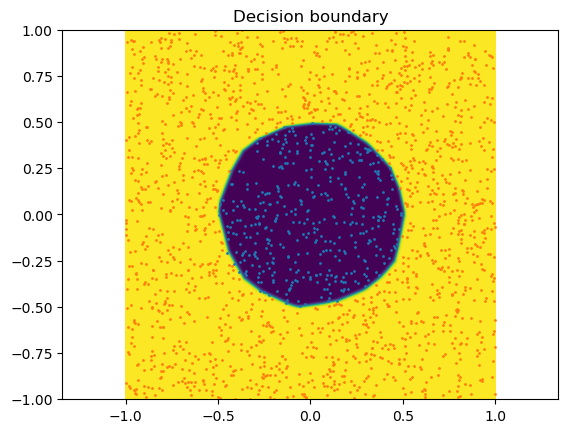

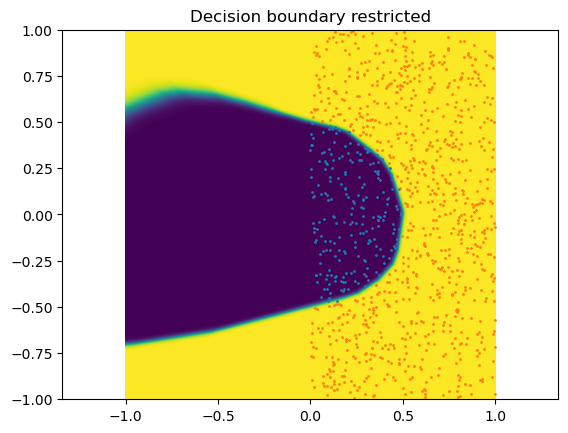

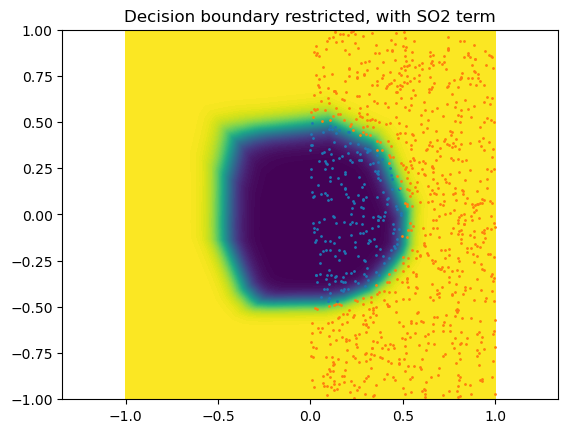

In [13]:
# Plot the decision boundary for both models
nn=300

x = np.linspace(-1, 1, nn)
y = np.linspace(-1, 1, nn)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(nn):
    for j in range(nn):
        Z[i, j] = model(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).detach().numpy()

plt.figure()
plt.contourf(X, Y, Z, levels=100)
plt.scatter(train_data[train_labels == 0, 0], train_data[train_labels == 0, 1], s=1)
plt.scatter(train_data[train_labels == 1, 0], train_data[train_labels == 1, 1], s=1)
plt.axis('equal')
plt.title("Decision boundary")
plt.show()

Z = np.zeros_like(X)

for i in range(nn):
    for j in range(nn):
        Z[i, j] = model_restricted(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).item()

plt.figure()
plt.contourf(X, Y, Z, levels=100)
plt.scatter(train_data_restriced[train_labels_restriced == 0, 0], train_data_restriced[train_labels_restriced == 0, 1], s=1)
plt.scatter(train_data_restriced[train_labels_restriced == 1, 0], train_data_restriced[train_labels_restriced == 1, 1], s=1)
plt.axis('equal')
plt.title("Decision boundary restricted")
plt.show()



Z = np.zeros_like(X)

for i in range(nn):
    for j in range(nn):
        Z[i, j] = model_restricted_SO2(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)).item()

plt.figure()
plt.contourf(X, Y, Z, levels=100)
plt.scatter(train_data_restriced[train_labels_restriced == 0, 0], train_data_restriced[train_labels_restriced == 0, 1], s=1)
plt.scatter(train_data_restriced[train_labels_restriced == 1, 0], train_data_restriced[train_labels_restriced == 1, 1], s=1)
plt.axis('equal')
plt.title("Decision boundary restricted, with SO2 term")
plt.show()




In [228]:
N=100
n=13

Z=[0]*(N+1)
for i in reversed(range(N)):
    up=min(i+n,N)
    down=i+1
    Z[i]=1+sum(Z[z] for z in range(down,up+1))/n

print(Z[0])



14.857142802436146


In [229]:
import random
avg=0
n_exp=10000
for _ in range(n_exp):
    s=0
    T=0
    while s<N:
        T+=1
        s+=random.randrange(1,n+1)
    avg+=T/n_exp
avg

14.855300000000112

In [266]:
N = 10  # Maximum step increment
n = 17  # Stopping criterion threshold
k = 21  # Maximum at stopping (calculating prob of stopping in [n, k])

Z = [0] * n  # Include n states, from 0 to n-1
Z[n-1] = (min(k, n-1 + N) - n + 1) / N  # Probability from the last position before n

# Iterate backwards from n-2 down to 0
for i in reversed(range(n-1)):
    if i >= n-N:  # Check if direct jumps to [n, k] are possible from i
        direct_stop = (min(k, i + N) - n + 1) / N
    else:
        direct_stop = 0

    # Sum up probabilities from i+1 to min(i+N, n-1)
    progressive_prob = sum(Z[s] for s in range(i+1, min(i+N, n))) / N

    Z[i] = direct_stop + progressive_prob  # Combine direct and progressive probabilities

# If required to print or check the initial probability at s = 0
print("Probability that S stops in [n, k] starting from s = 0:", Z[0])


Probability that S stops in [n, k] starting from s = 0: 0.605884437068608


In [298]:
Z=[1,2,3,4]
Z[2:4]=[6,7]
Z

[1, 2, 6, 7]

In [8]:
5//2+1

3

In [6]:
0.02**2/300 ,0.01**2/100

(1.3333333333333334e-06, 1e-06)

In [10]:
0.1**3.11/2,0.08**3.11

(0.000388123558314346, 0.00038780183482460404)

In [13]:
np.log(2)/np.log(0.1/0.08)

3.10628371950539

In [293]:
import random
avg=0
n_exp=1000000

N=3
k=3
n=4
for _ in range(n_exp):
    s=0
    
    while s<k:
        
        s+=random.randrange(1,N+1)
    if s<=n:
        avg+=1/n_exp
avg

0.851499000003648

In [295]:
p=1/3.0
p2=2*p
p1=p*(p2+2)
p*(p1+p2)+p

0.8518518518518516